In [4]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow
from time import time


# Data Augmentation

In [5]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [6]:
img = load_img('/data/oxford102/jpg/image_00001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='flower', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)
(500, 591, 3)


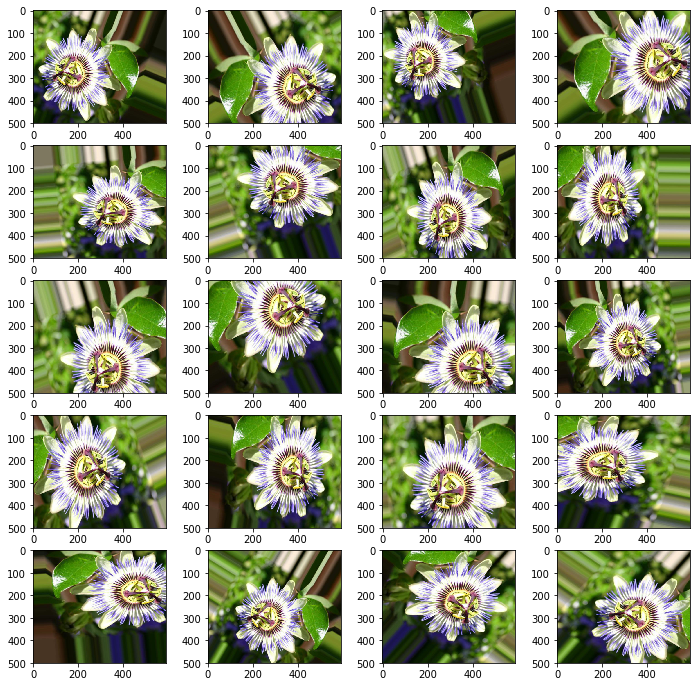

In [7]:
category = "/data/preview/"
imgs = np.random.choice(os.listdir(category), size=20, replace=False)
#os.listdir(category)

w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    img=mpimg.imread(category + imgs[i-1])
    print(img.shape)
    imgplot = plt.imshow(img)
plt.show()

# Train small convnet

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [21]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(102, activation="softmax"))
#model.add(Activation('sigmoid'))


# #Adding custom Layers 
# x = model.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# #x = Dense(1024, activation="relu")(x)
# predictions = Dense(nr_categories, activation="softmax")(x)



model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', 
              #optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])

#model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_9 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [19]:
batch_size = 16

# this is the augmentation configuration we will use for training
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/data/oxford102/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/data/oxford102/val',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 5698 images belonging to 102 classes.
Found 2441 images belonging to 102 classes.


In [9]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)



In [10]:
model.fit_generator(
        train_generator,
        steps_per_epoch=5698 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2441 // batch_size,
        callbacks = [checkpoint, early, tensorboard])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
356/356 [==============================] - 129s 362ms/step - loss: 4.1382 - acc: 0.0755 - val_loss: 3.5624 - val_acc: 0.1591

Epoch 00001: val_acc improved from -inf to 0.15913, saving model to vgg16_all_p2.h5
Epoch 2/50
356/356 [==============================] - 114s 320ms/step - loss: 3.4829 - acc: 0.1606 - val_loss: 3.0388 - val_acc: 0.2549

Epoch 00002: val_acc improved from 0.15913 to 0.25493, saving model to vgg16_all_p2.h5
Epoch 3/50
356/356 [==============================] - 114s 320ms/step - loss: 3.0876 - acc: 0.2428 - val_loss: 2.7426 - val_acc: 0.3059

Epoch 00003: val_acc improved from 0.25493 to 0.30592, saving model to vgg16_all_p2.h5
Epoch 4/50
356/356 [==============================] - 115s 324ms/step - loss: 2.8135 - acc: 0.2995 - val_loss: 2.5834 - val_acc: 0.3544

Epoch 00004: val_acc improved from 0.30592 to 0.35444, saving model to vgg16_all_p2.h5
Epoch 5/50
356/356 [==============================] - 114s 320ms/step - loss: 2.5756 - acc: 0.3436 - val_lo

# optimizer=SGD

In [15]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_sgd.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)

In [16]:
model.fit_generator(
        train_generator,
        steps_per_epoch=5698 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2441 // batch_size,
        callbacks = [checkpoint, early, tensorboard])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
356/356 [==============================] - 114s 320ms/step - loss: 4.6108 - acc: 0.0170 - val_loss: 4.5910 - val_acc: 0.0189

Epoch 00001: val_acc improved from -inf to 0.01891, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 2/50
356/356 [==============================] - 114s 320ms/step - loss: 4.5813 - acc: 0.0242 - val_loss: 4.5587 - val_acc: 0.0362

Epoch 00002: val_acc improved from 0.01891 to 0.03618, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 3/50
356/356 [==============================] - 114s 319ms/step - loss: 4.5638 - acc: 0.0251 - val_loss: 4.5389 - val_acc: 0.0354

Epoch 00003: val_acc did not improve from 0.03618
Epoch 4/50
356/356 [==============================] - 114s 320ms/step - loss: 4.5526 - acc: 0.0270 - val_loss: 4.5243 - val_acc: 0.0329

Epoch 00004: val_acc did not improve from 0.03618
Epoch 5/50
356/356 [==============================] - 114s 319ms/step - loss: 4.5374 - acc: 0.0297 - val_loss: 4.5045 - val_acc: 0.0391

Ep

356/356 [==============================] - 113s 319ms/step - loss: 3.2517 - acc: 0.1984 - val_loss: 3.0567 - val_acc: 0.2562

Epoch 00036: val_acc improved from 0.25452 to 0.25617, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 37/50
356/356 [==============================] - 112s 315ms/step - loss: 3.1939 - acc: 0.2214 - val_loss: 3.0105 - val_acc: 0.2599

Epoch 00037: val_acc improved from 0.25617 to 0.25987, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 38/50
356/356 [==============================] - 112s 313ms/step - loss: 3.1559 - acc: 0.2221 - val_loss: 2.9975 - val_acc: 0.2627

Epoch 00038: val_acc improved from 0.25987 to 0.26275, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 39/50
356/356 [==============================] - 111s 311ms/step - loss: 3.1410 - acc: 0.2323 - val_loss: 2.9733 - val_acc: 0.2854

Epoch 00039: val_acc improved from 0.26275 to 0.28536, saving model to /data/oxford102/small_convnet_sgd.h5
Epoch 40/50
356/356 [=======

# With Data augmentation

In [23]:
checkpoint = ModelCheckpoint("/data/oxford102/small_convnet_rmsprop_more_augmentation.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0, write_graph=True, write_images=True)
model.fit_generator(
        train_generator,
        steps_per_epoch=5698 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=2441 // batch_size,
        callbacks = [checkpoint, early, tensorboard])
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
356/356 [==============================] - 115s 323ms/step - loss: 4.2427 - acc: 0.0620 - val_loss: 3.7434 - val_acc: 0.1172

Epoch 00001: val_acc improved from -inf to 0.11719, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 2/50
356/356 [==============================] - 115s 324ms/step - loss: 3.6455 - acc: 0.1178 - val_loss: 3.2986 - val_acc: 0.1945

Epoch 00002: val_acc improved from 0.11719 to 0.19449, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 3/50
356/356 [==============================] - 115s 322ms/step - loss: 3.3467 - acc: 0.1733 - val_loss: 3.0784 - val_acc: 0.2484

Epoch 00003: val_acc improved from 0.19449 to 0.24836, saving model to /data/oxford102/small_convnet_rmsprop_more_augmentation.h5
Epoch 4/50
356/356 [==============================] - 115s 322ms/step - loss: 3.1507 - acc: 0.2242 - val_loss: 3.4569 - val_acc: 0.2270

Epoch 00004: val_acc did not improve from 0.24836
Epoch 5/50
356/